In [1]:
# Run this block before anything else

%env PYTHONPATH=
!wget -c https://repo.anaconda.com/miniconda/Miniconda3-4.5.4-Linux-x86_64.sh
!chmod +x Miniconda3-4.5.4-Linux-x86_64.sh
!bash ./Miniconda3-4.5.4-Linux-x86_64.sh -b -f -p /usr/local
!rm ./Miniconda3-4.5.4-Linux-x86_64.sh
!conda install -q -y --prefix /usr/local python=3.7 cartopy
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages')
%matplotlib inline

import scipy.io.netcdf as sp
import matplotlib.pyplot as plt
import numpy as np

!pip install cartopy
import cartopy.crs as ccrs
import cartopy.feature as cf
from cartopy.util import add_cyclic_point

from google.colab import drive
drive.mount('/content/drive')

env: PYTHONPATH=
--2022-02-24 14:05:37--  https://repo.anaconda.com/miniconda/Miniconda3-4.5.4-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.130.3, 104.16.131.3, 2606:4700::6810:8203, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.130.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 58468498 (56M) [application/x-sh]
Saving to: ‘Miniconda3-4.5.4-Linux-x86_64.sh’

Miniconda3-4.5.4-Li 100%[===================>]  55.76M   130MB/s    in 0.4s    

2022-02-24 14:05:38 (130 MB/s) - ‘Miniconda3-4.5.4-Linux-x86_64.sh’ saved [58468498/58468498]

PREFIX=/usr/local
installing: python-3.6.5-hc3d631a_2 ...
Python 3.6.5 :: Anaconda, Inc.
installing: ca-certificates-2018.03.07-0 ...
installing: conda-env-2.6.0-h36134e3_1 ...
installing: libgcc-ng-7.2.0-hdf63c60_3 ...
installing: libstdcxx-ng-7.2.0-hdf63c60_3 ...
installing: libffi-3.2.1-hd88cf55_4 ...
installing: ncurses-6.1-hf484d3e_0 ...
installing: openssl-1.0.2o-h20670df_0 ...
i

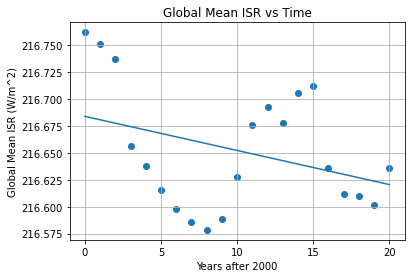

In [2]:
# This script creates a global contour map of the mean RSR values at each location

# Open the dataset file
fileObj = sp.NetCDFFile('/content/drive/My Drive/Classroom/Research Project 2022/Data/CERES_EBAF-TOA_Ed4.1_Subset_200003-202111.nc', 'r')

# Make variables to store all the ISR and latitude values
ISR = fileObj.variables['solar_mon'][:]
lat = fileObj.variables['lat'][:]

# Calculate how many full years of data is in the dataset
numYears = ISR.shape[0] // 12

# Create an array that stores a value for each year after 2000, with the year 2000 at index 0
years = np.arange(numYears)

# Create an array, with 0s as placeholders, that will be used to store the global mean ISR of each year
yearlyGlobalMeanISR = np.zeros(numYears)

# Loop through each year and calculate the global mean ISR during that time
for i in range(numYears):
    # Store 12 months of ISR data
    oneYearISR = ISR[i*12:i*12+12, :, :]
    
    # Average the data at each location across all 12 months
    meanYearISR = oneYearISR.mean(axis=0)
    
    # Average the data all longitude coordinates
    meanYearLonISR = meanYearISR.mean(axis=1)
    
    # Weight the data depending on its latitude coordinates, with data from locations farther from the equator given less weight since it represents a smaller area
    for j in range(lat.shape[0]):
        meanYearLonISR[j] *= np.cos(lat[j] * np.pi/180)
    
    # Average the data across all latitude coordinates
    yearlyGlobalMeanISR[i] = meanYearLonISR.mean(axis=0)

# Calculate the slope, y-intercept, and correlation coefficient of the best-fit line through the ISR-vs-time points
m, b = np.polyfit(years, yearlyGlobalMeanISR, 1)
r = np.corrcoef(years, yearlyGlobalMeanISR)[0,1]

# Create a scatter plot of the global mean ISR values over time, and then plot the best-fit line through the points
plt.scatter(years, yearlyGlobalMeanISR)
plt.plot(years, m * years + b)

# Adjust the viewing window of the graph, and place a text box containing the equation of the best-fit line and value of the correlation coefficient. Un-comment the next two lines by deleting the '#'s for this to take effect.
#plt.axis([0, 20, 0, 400])
#plt.text(10, 50, 'ISR = ' + f'{m:.4g}' + '*t + ' + f'{b:.4g}' + '\nr = ' + f'{r:.4g}')

# Add a title and labels to the horizontal and vertical axes. Then adjust how many ticks are on the horizontal axis and add gridlines.
plt.title('Global Mean ISR vs Time')
plt.xlabel('Years after 2000')
plt.ylabel('Global Mean ISR (W/m^2)')
plt.locator_params(axis='x', nbins=5)
plt.grid()

# Save a PNG image of the map
plt.savefig('/content/drive/My Drive/Research Project/ISR_Time_ScatterPlot.png', bbox_inches='tight', dpi=200)